# Part 2: Denoising Autoencoder

In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

### Extend the Autoencoder you implemented in Part 1 to a Denoising Autoencoder

Recall from the lecture, a denoising autoencoder's architecture is very similar to a standard autoencoder. The difference is the input to the autoencoder has noise added to it. However, when computing the loss function, make sure the original (non-noisy) version is used for backpropagation.

Again, let's start by loading the Fashion-MNIST dataset and transforming it to a flattened tensor.

In [0]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

import numpy as np

batch_size = 256
image_dim = 784  # [flattened]

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

26427392it [00:00, 66473193.80it/s]                              


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 407395.52it/s]
  5%|▍         | 212992/4422102 [00:00<00:02, 1921408.67it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 25168623.24it/s]                           
8192it [00:00, 99169.46it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## Build a Denoising Autoencoder

Now, define the Encoder and Decoder classes for your denoising autoencoder, called DN_Encoder, DN_Decoder, respectively. You can define these architectures how you like; some suggested architectures are given as comments in the classes below.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from itertools import chain


class DN_Encoder(nn.Module):
    '''
    Denoising encoder with a single input, hidden and output layer
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DN_Encoder, self).__init__()
        # YOUR CODE HERE
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)
       
    
    def forward(self, x):
        # YOUR CODE HERE
        out = self.lin1(x)
        out = F.relu(out)
        out = self.lin2(out)
        return out


        
class DN_Decoder(nn.Module):
    '''
    Denoising decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DN_Decoder, self).__init__()
        # YOUR CODE HERE
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.lin1(x)
        out = F.relu(out)
        out = self.lin2(out)
        out = torch.sigmoid(out)
        return out

## Learning your Denoising Autoencoder 

Start from the training procedure used in Part 1 for the autoencoder and extend this to get your denoising autoencoder working. Again, include images of both the data with added noise as well as the reconstructed images in the submitted notebook. Regarding the noise to add to your images, add Gaussian noise with a mean of 0 and a standard deviation of 1.

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


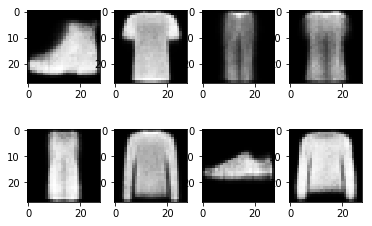

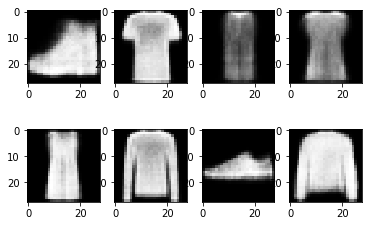

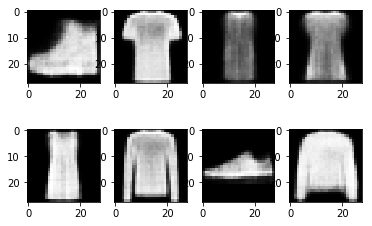

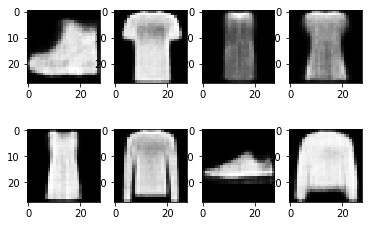

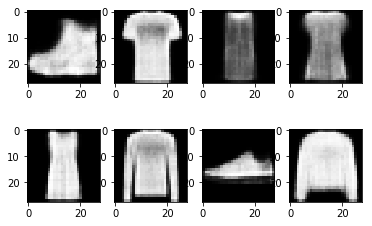

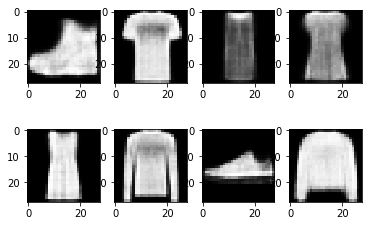

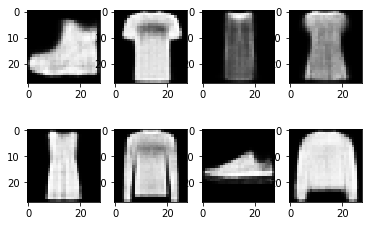

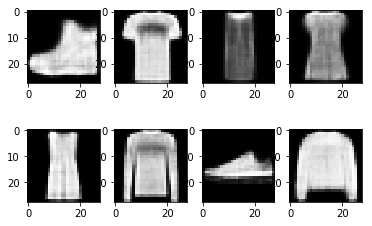

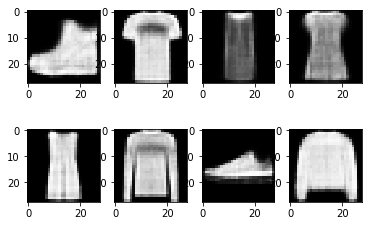

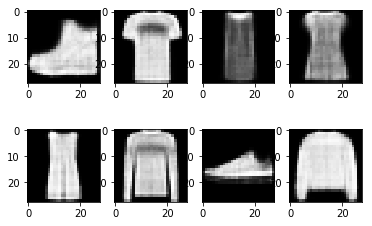

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

from tqdm import tqdm_notebook as tqdm
from itertools import chain

enc_dim = 64
hidden_dim = 512
image_dim = 784  # [flattened]
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = DN_Encoder(image_dim,hidden_dim, enc_dim)
dec = DN_Decoder(enc_dim, hidden_dim, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(train_loader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        z = enc(inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    
    
    ## Display some of the reconstructed images
    # YOUR CODE HERE
    enc.eval()
    dec.eval()
    
    for i in range(8):
      input_ims = train_loader.dataset[i][0]
      inputs = enc(input_ims)
      outputs = dec(inputs)
      plt.subplot(int(str(24)+str(i+1)))
      plt.imshow(outputs.detach().numpy().reshape((28,28)),cmap = plt.get_cmap('gray'))
      
    plt.show()